# Compute the Stopping Distance for a Projectile
Compute the stopping distance of a projectile using the multi-velocity machine learning model.

* lower the rtol and atol and see how these curves change, and quantify the difference as a function of rtol
* change the initial position and quantify the difference between two curves

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import sys
sys.path.append(f"{os.getcwd()}/../../")
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from stopping_power_ml.stop_distance import StoppingDistanceComputer
from stopping_power_ml.integrator import TrajectoryIntegrator
import pickle as pkl
import pandas as pd
import numpy as np
import keras
import os
from glob import glob

# plt.style.use(['notebook', 'no-latex'])

2024-06-24 12:16:21.945598: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 12:16:21.946381: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 12:16:23.706028: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 12:16:27.298054: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 12:18:26.729682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## Load in the Model and Featurizer
The model is saved in Keras h5, and the featurizer is in the root directory

In [2]:
with open(os.path.join('..', 'featurizer.pkl'), 'rb') as fp:
    featurizers = pkl.load(fp)

start_frame = pkl.load(open(os.path.join('..', '..', 'al_starting_frame.pkl'), 'rb'))

# channel_data = pd.read_pickle(os.path.join('..', '..', 'single-velocity', 'data', 'channel_data.pkl.gz')).query('average_range')

min_velocity = pd.read_pickle(os.path.join('..', '..', 'training_data.pkl.gz'))['velocity_mag'].min()
max_velocity = pd.read_pickle(os.path.join('..', '..', 'training_data.pkl.gz'))['velocity_mag'].max()
print(min_velocity, max_velocity)

0.49999965530500606 4.000000001113168


## compare single precision vs double precision

In [3]:
# randint = 58
# lall = ['single', 'double']
# fall = [f"../random_models/sp58.dat", f"../random_models/double_sp58.dat"]
# ls_all = ['-', ':']
# for i, f in enumerate(fall):
#     dat = np.loadtxt(f)
#     l1, = plt.plot(dat[:, 0], dat[:, 1], ls = ls_all[i],label = lall[i])
#     plt.plot(dat[:, 0], dat[:, 2], ls = ls_all[i])

# plt.ylim([None, 0.3])
# plt.legend()
# plt.axvline(min_velocity, c = 'k', ls = '--', alpha = 0.3)
# plt.axvline(max_velocity, c = 'k', ls = '--', alpha = 0.3)
# plt.xlabel('Velocity (a.u.)')
# plt.ylabel('Stopping Power ($E_H / a_B$)')


In [19]:
model_all = [f'../random_models/single_model.h5', f'../random_models/double_model48.h5']
dist_all = []
pos_all = []
position = np.random.random(3)
print(f'position = {position}')
#position = [0.45, 0.768, 0.3]
velocity = [4, 0, 0]
for m in model_all:
    model = keras.models.load_model(m)
    
    traj_int = TrajectoryIntegrator(start_frame, model, featurizers)
    stop_comp = StoppingDistanceComputer(traj_int)
    stop_comp.max_step = np.inf
    stop_comp.rtol = 1e-5
    stop_comp.atol = 1e-6
    
    dist, pos = stop_comp.compute_stopping_distance(position, velocity, output=1)
    dist_all.append(dist)
    pos_all.append(pos)
    print(f'Stopping distance: {dist:.2f} a_B')

position = [0.69179333 0.36906984 0.91509621]


KeyboardInterrupt: 

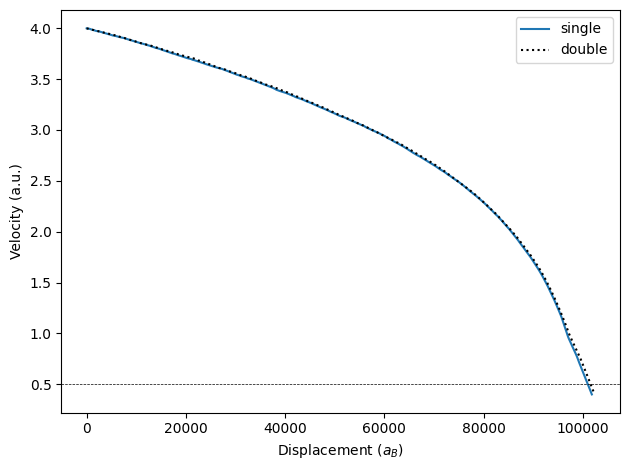

In [15]:
fig, ax = plt.subplots()

ax.plot(pos_all[0]['displacement'], pos_all[0]['velocity'], label = 'single')

ax.plot(pos_all[1]['displacement'], pos_all[1]['velocity'], ls = ':', c = 'k', label = 'double')


ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Velocity (a.u.)')

# Plot the stopping distance and time
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), [min_velocity]*2, 'k--', lw=0.5)
# ax.plot([dist_channel]*2, ax.get_ylim(), 'k--', lw=0.5)
plt.legend()

# fig.set_size_inches(3.5, 2)
fig.tight_layout()

## Compare different masses

In [8]:
m = '../model_random_and_channel_single_58.h5'
scaler_all = [0.8, 0.9, 1, 1.1, 1.2, 2]
dist_all = []
pos_all = []
for scaler in scaler_all:
    model = keras.models.load_model(m)
    
    traj_int = TrajectoryIntegrator(start_frame, model, featurizers)
    stop_comp = StoppingDistanceComputer(traj_int)
    stop_comp.max_step = np.inf
    stop_comp.proj_mass *= scaler
    dist, pos = stop_comp.compute_stopping_distance([0, 0.75, 0.75], [4, 0, 0], output=1)
    dist_all.append(dist)
    pos_all.append(pos)
    print(f'Stopping distance: {dist:.2f} a_B')

Step: 48 - Time: 34867.403507676325 - Velocity: 0.3939829704536946 - Position: 84020.38153406381994509


Stopping distance: 83986.47 a_B
Step: 47 - Time: 41930.235499612485 - Velocity: 0.3800262060174476 - Position: 105677.3033138688645236


Stopping distance: 105549.99 a_B
Step: 47 - Time: 46378.30969640901 - Velocity: 0.3646068716175329 - Position: 115099.3823948538929791


Stopping distance: 114909.85 a_B
Step: 54 - Time: 46355.25674047792 - Velocity: 0.389009957933377 - Position: 112204.937907277986549143


Stopping distance: 112136.38 a_B
Step: 44 - Time: 51877.61819508769 - Velocity: 0.3794148168015101 - Position: 127098.1934220751142532


Stopping distance: 126918.80 a_B
Step: 49 - Time: 89186.42892382522 - Velocity: 0.3800806342781083 - Position: 217876.5744099713374479
Stopping distance: 217688.58 a_B


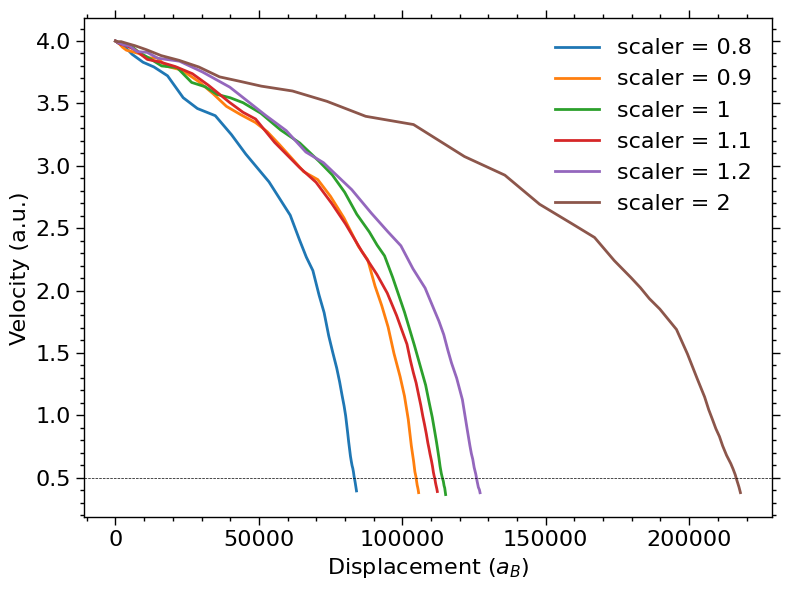

In [10]:
fig, ax = plt.subplots()

for i, pos in enumerate(pos_all):
    ax.plot(pos['displacement'], pos['velocity'], label = f'scaler = {scaler_all[i]}')



ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Velocity (a.u.)')

# Plot the stopping distance and time
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), [min_velocity]*2, 'k--', lw=0.5)
# ax.plot([dist_channel]*2, ax.get_ylim(), 'k--', lw=0.5)

plt.legend()

# fig.set_size_inches(3.5, 2)
fig.tight_layout()

## compare different random seeds

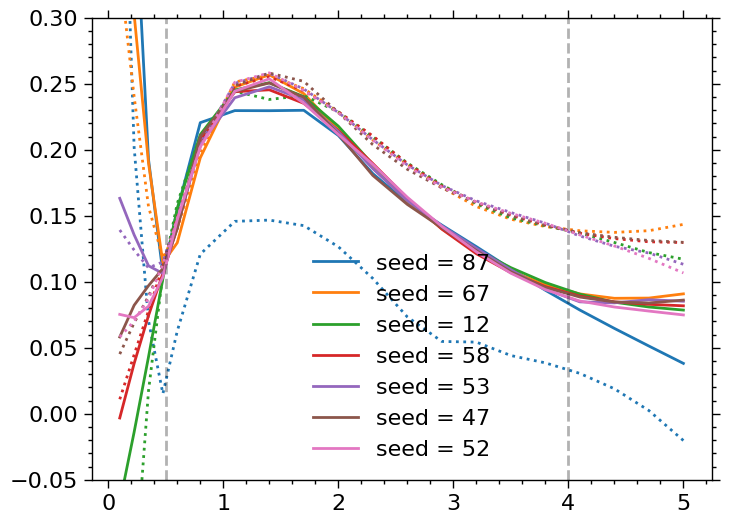

In [37]:
fall = glob("../random_models/sp*.dat")
for i, f in enumerate(fall):
    seed = f.split("sp")[1].split(".dat")[0]
    dat = np.loadtxt(f)
    l1, = plt.plot(dat[:, 0], dat[:, 1], label = f"seed = {seed}")
    plt.plot(dat[:, 0], dat[:, 2], ls = ':', c = l1.get_color())

plt.ylim([-0.05, 0.3])
plt.legend()
plt.axvline(min_velocity, c = 'k', ls = '--', alpha = 0.3)

plt.axvline(max_velocity, c = 'k', ls = '--', alpha = 0.3)

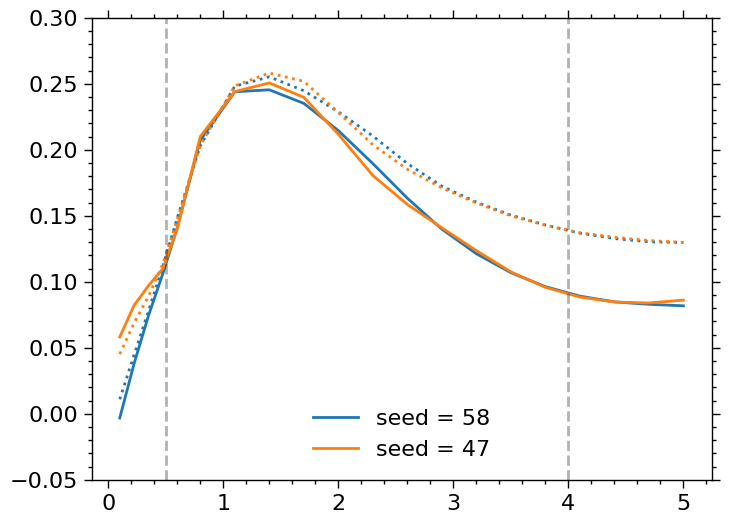

In [36]:
fall = glob("../random_models/sp58.dat")+glob("../random_models/sp47.dat")
for i, f in enumerate(fall):
    seed = f.split("sp")[1].split(".dat")[0]
    dat = np.loadtxt(f)
    l1, = plt.plot(dat[:, 0], dat[:, 1], label = f"seed = {seed}")
    plt.plot(dat[:, 0], dat[:, 2], ls = ':', c = l1.get_color())

plt.ylim([-0.05, 0.3])
plt.legend()
plt.axvline(min_velocity, c = 'k', ls = '--', alpha = 0.3)

plt.axvline(max_velocity, c = 'k', ls = '--', alpha = 0.3)


In [33]:
model_all = [f'../random_models/model58.h5', f'../random_models/model47.h5']
dist_all = []
pos_all = []
for m in model_all:
    model = keras.models.load_model(m)
    
    traj_int = TrajectoryIntegrator(start_frame, model, featurizers)
    stop_comp = StoppingDistanceComputer(traj_int)
    stop_comp.max_step = np.inf
    
    dist, pos = stop_comp.compute_stopping_distance([0, 0.75, 0.75], [4, 0, 0], output=1)
    dist_all.append(dist)
    pos_all.append(pos)
    print(f'Stopping distance: {dist:.2f} a_B')

Step: 47 - Time: 46378.30969640901 - Velocity: 0.3646068716175329 - Position: 115099.3823948538929791


Stopping distance: 114909.85 a_B
Step: 47 - Time: 39802.41681066016 - Velocity: 0.3934950209629694 - Position: 95597.2450220316166961334
Stopping distance: 95551.76 a_B


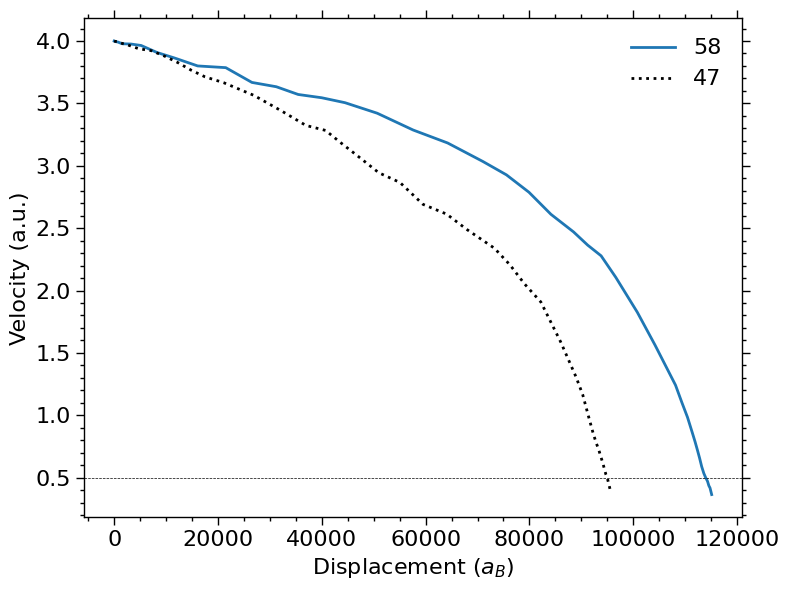

In [35]:
fig, ax = plt.subplots()

ax.plot(pos_all[0]['displacement'], pos_all[0]['velocity'], label = '58')

ax.plot(pos_all[1]['displacement'], pos_all[1]['velocity'], ls = ':', c = 'k', label = '47')


ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Velocity (a.u.)')

# Plot the stopping distance and time
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot(ax.get_xlim(), [min_velocity]*2, 'k--', lw=0.5)
# ax.plot([dist_channel]*2, ax.get_ylim(), 'k--', lw=0.5)
plt.legend()

# fig.set_size_inches(3.5, 2)
fig.tight_layout()